<a href="https://www.kaggle.com/code/avikumart/timeseries-stock-price-forecasting?scriptVersionId=104818130" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# <h1 style='background:red; border:0; border-radius: 10px; color:black'><center> INTRODUCTION </center></h1>
## **What is a Time Series??**⏲📈

- Time-series is series of obeservations that are recorded over a period of time. these observations are dependent of time component which can not be neglected thus we have have to analysis the this data keeping time component in mind.

<img src = "https://miro.medium.com/max/1400/0*j8LjgYr1r1xPrJkr.gif" width = 900 height = 400/>

### **Time Series Forecasting**

- Time series forecasting is parhaps one of the most common type of machine learning techniques used in real-world scenarios. `time-sereis forecsting refers to predicting future values from historical data by statical analysis of trends and patterns from certain time-series data.` it falls under unsupervised learning category but called as a self-supervised learning or supervised learning technique. time-series data can be much complex to find patterns out of it, this is because irregular component of time series. 

## **Use-cases and applications:**
- Forecast product demand
- Economic growth and population forecasting
- Weather forecasting
- Stock price forecasting
- Sales/Revenue forecasting
- Web-traffic forecasting


## **Problem-statement**

- In this notebook, our problem-statement is to analyse S&P500 stock prices (We will analyze 10 popular stocks and forecast the future prices) and build forecasting models that beat the market.

roadmap: 1)explore the data 2) analysis of the data 3) interpretation 4) forecasting models (why some models and some don't, experiments and exaplanation with useful tips)


**this notebook is under progress!⚠**

# <h1 style='background:green; border:0; border-radius: 10px; color:black'><center> Importing Libraries</center></h1>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

%matplotlib inline

# matplotlib defaults
plt.style.use("fivethirtyeight")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

import warnings
warnings.filterwarnings("ignore")

# <h1 style='background:red; border:0; border-radius: 10px; color:black'><center> Data analysis and visualizations </center></h1>

In [2]:
# read the dataframe
df = pd.read_csv("../input/sandp500/all_stocks_5yr.csv")
df.head().style.set_properties(**{'background-color': 'black',
                                    'color': 'lawngreen',
                                    'border': '1.5px  white'})

,date,open,high,low,close,volume,Name
0,2013-02-08,15.070000,15.120000,14.630000,14.750000,8407500,AAL
1,2013-02-11,14.890000,15.010000,14.260000,14.460000,8882000,AAL
2,2013-02-12,14.450000,14.510000,14.100000,14.270000,8126000,AAL
3,2013-02-13,14.300000,14.940000,14.250000,14.660000,10259500,AAL
4,2013-02-14,14.940000,14.960000,13.160000,13.990000,31879900,AAL


In [3]:
def information_func(df):
    
    # unique stocks
    print("Uniques stocks available in dataset:", df['Name'].nunique())
    print("----"*20)
    
    # metadata of dataset
    print("Metadata of the dataset:\n")
    df.info()
    print("----"*20)
    
    # missing values
    null = df.isnull().sum()
    print(null)
    print("----"*20)
    
    # max range of stocks dataset
    delta = (pd.to_datetime(df['date']).max() - pd.to_datetime(df['date']).min())
    print("Time range of stocks dataset:\n", delta)
    print("----"*20) 

In [4]:
information_func(df)

Uniques stocks available in dataset: 505
--------------------------------------------------------------------------------
Metadata of the dataset:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 619040 entries, 0 to 619039
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    619040 non-null  object 
 1   open    619029 non-null  float64
 2   high    619032 non-null  float64
 3   low     619032 non-null  float64
 4   close   619040 non-null  float64
 5   volume  619040 non-null  int64  
 6   Name    619040 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 33.1+ MB
--------------------------------------------------------------------------------
date       0
open      11
high       8
low        8
close      0
volume     0
Name       0
dtype: int64
--------------------------------------------------------------------------------
Time range of stocks dataset:
 1825 days 00:00:00
---------------------

### <h1 style='background:#4bd659; border:0; border-radius: 10px; color:black'><right> Data cleaning </right></h1>

In [5]:
# rename Name to ticks
rdf = df.rename(columns={'Name':'ticks'})

# drop the null as they a few values and time-series won't be affected by such values
rdf.dropna(inplace=True)

# change the dtype of date column
new_df = rdf.copy()
new_df.loc[:, 'date'] = pd.to_datetime(rdf.loc[:, 'date'], format='%Y/%m/%d')

# new dataframe info
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 619029 entries, 0 to 619039
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    619029 non-null  datetime64[ns]
 1   open    619029 non-null  float64       
 2   high    619029 non-null  float64       
 3   low     619029 non-null  float64       
 4   close   619029 non-null  float64       
 5   volume  619029 non-null  int64         
 6   ticks   619029 non-null  object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 37.8+ MB


### <h1 style='background:#ed615c; border:0; border-radius: 10px; color:black'><right> Top 10 stock tickers by average trade volume </right></h1>

In [6]:
# find the average volume of each stocks using function and sort top 10 most traded stocks for further analysis 
mean_dict = {}

# find average of volume traded over a period of time using for loops
for key in new_df['ticks'].unique():
    value = new_df[new_df['ticks'] == key ]['volume'].mean()
    mean_dict[key]= value

print("Length of the mean of ticks dictionary:", len(mean_dict))

# convert dict to pandas dataframe
avaerage_s = pd.Series(mean_dict).transpose()
top10_s = avaerage_s.sort_values(ascending=False)[:10]

print("Top 10 company tickers with highest average traded stock volume:\n", top10_s.index)

Length of the mean of ticks dictionary: 505
Top 10 company tickers with highest average traded stock volume:
 Index(['BAC', 'AAPL', 'GE', 'F', 'FB', 'MSFT', 'AMD', 'MU', 'INTC', 'CSCO'], dtype='object')


In [7]:
# function to return top 10 sub dataframe
def subdataframe(df, tick):
    
    # top 10 ticks
    ticks = list(top10_s.index)
    
    assert tick in ticks, """Stock tick does not belong to top 10 stocks by trade volume, please try any of these:\n
    ['BAC', 'AAPL', 'GE', 'F', 'FB', 'MSFT', 'AMD', 'MU', 'INTC', 'CSCO']"""
    
    ndf = new_df[new_df['ticks'] == tick]
    return ndf

In [8]:
# company dict for respective ticks (TOP 10 STOCKS BY AVERAGE TRAE VOLUME)
company_dict = {'BAC':'Bank of America', 
                'AAPL':'Apple', 
                'GE':'General Electric', 
                'F':'Ford Motor Company', 
                'FB':'Facebook', 
                'MSFT':'Microsoft', 
                'AMD':'Adavanced Micro Devices', 
                'MU':'Micron Technology', 
                'INTC':'Intel Corp', 
                'CSCO':'Cisco'
               }
# assign daily return and company name column (VIZ)
# trade volume of each stocks avg, min and max during time period (viz)
# stock price visualizations
# ohlc and candle stick charts
# reletive performance of stocks to pick best stocks
# forecasting models and insights to takeaway

bac_df = subdataframe(new_df, 'BAC')
aapl_df = subdataframe(new_df, 'AAPL')
ge_df = subdataframe(new_df, 'GE')
f_df = subdataframe(new_df, 'F')
fb_df = subdataframe(new_df, 'FB')
msft_df = subdataframe(new_df, 'MSFT')
amd_df = subdataframe(new_df, 'AMD')
mu_df = subdataframe(new_df, 'MU')
intc_df = subdataframe(new_df, 'INTC')
csco_df = subdataframe(new_df, 'CSCO')


# define a function to return daily return and company column
def dailyfunc(df):
    df['daily return'] = ((df['close'] - df['open'])/df['open'])*100
    df.style.format('{:.2f}%', subset='daily return')
    df['daily_mean'] = (df['open'] + df['close'] + df['high'] + df['low'])/4
    df['co_name'] = company_dict[df['ticks'].unique()[0]]
    return df

bac_df = dailyfunc(bac_df)
aapl_df = dailyfunc(aapl_df)
ge_df = dailyfunc(ge_df)
f_df = dailyfunc(f_df)
fb_df = dailyfunc(fb_df)
msft_df = dailyfunc(msft_df)
amd_df = dailyfunc(amd_df)
mu_df = dailyfunc(mu_df)
intc_df = dailyfunc(intc_df)
csco_df = dailyfunc(csco_df)

print('\t\tStart Date\t\t\t\t\tEnd Date')
print(f"BAC\t\t{bac_df['date'].min()}\t\t\t{bac_df['date'].max()}")
print(f"AAPL\t\t{aapl_df['date'].min()}\t\t\t{aapl_df['date'].max()}")
print(f"GE\t\t{ge_df['date'].min()}\t\t\t{ge_df['date'].max()}")
print(f"F\t\t{f_df['date'].min()}\t\t\t{f_df['date'].max()}")
print(f"FB\t\t{fb_df['date'].min()}\t\t\t{fb_df['date'].max()}")
print(f"MSFT\t\t{msft_df['date'].min()}\t\t\t{msft_df['date'].max()}")
print(f"AMD\t\t{amd_df['date'].min()}\t\t\t{amd_df['date'].max()}")
print(f"MU\t\t{mu_df['date'].min()}\t\t\t{mu_df['date'].max()}")
print(f"INTC\t\t{intc_df['date'].min()}\t\t\t{intc_df['date'].max()}")
print(f"CSCO\t\t{csco_df['date'].min()}\t\t\t{csco_df['date'].max()}")

		Start Date					End Date
BAC		2013-02-08 00:00:00			2018-02-07 00:00:00
AAPL		2013-02-08 00:00:00			2018-02-07 00:00:00
GE		2013-02-08 00:00:00			2018-02-07 00:00:00
F		2013-02-08 00:00:00			2018-02-07 00:00:00
FB		2013-02-08 00:00:00			2018-02-07 00:00:00
MSFT		2013-02-08 00:00:00			2018-02-07 00:00:00
AMD		2013-02-08 00:00:00			2018-02-07 00:00:00
MU		2013-02-08 00:00:00			2018-02-07 00:00:00
INTC		2013-02-08 00:00:00			2018-02-07 00:00:00
CSCO		2013-02-08 00:00:00			2018-02-07 00:00:00


### <h1 style='background:#4bd659; border:0; border-radius: 10px; color:black'><right> Closing stock price visualizations </right></h1>  

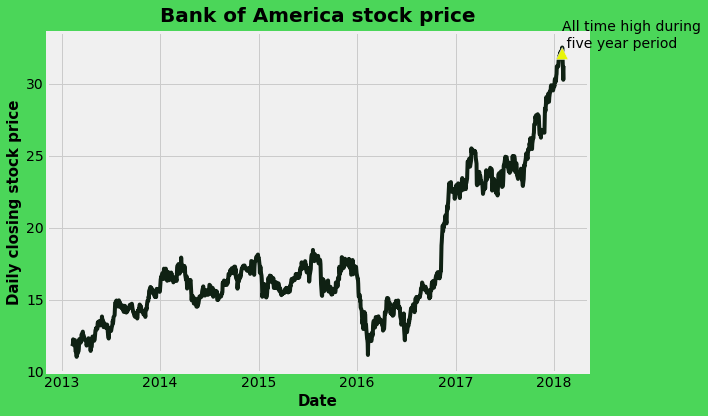

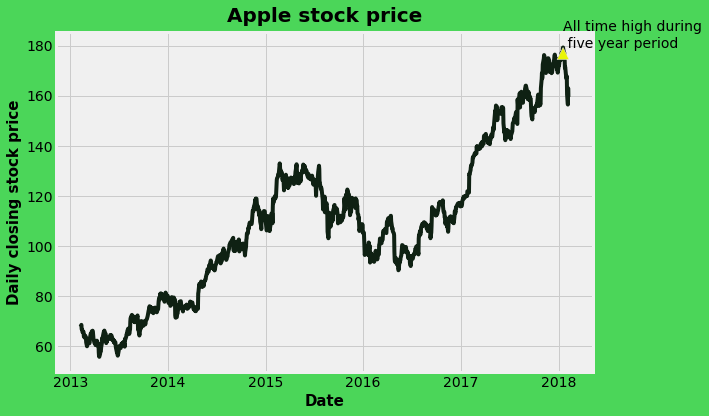

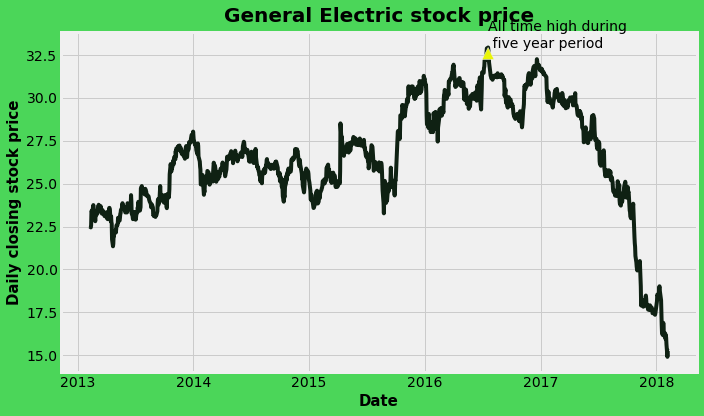

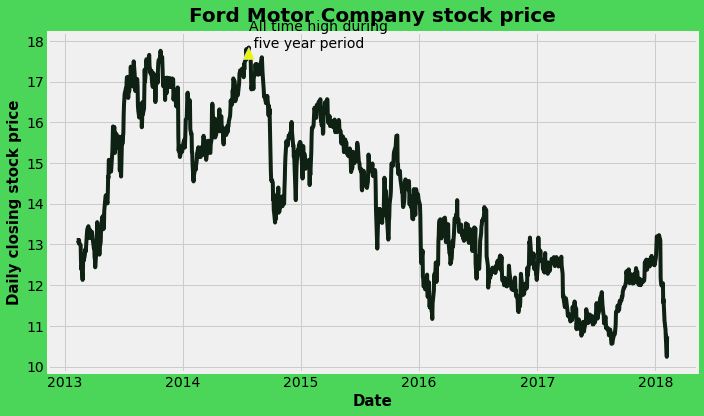

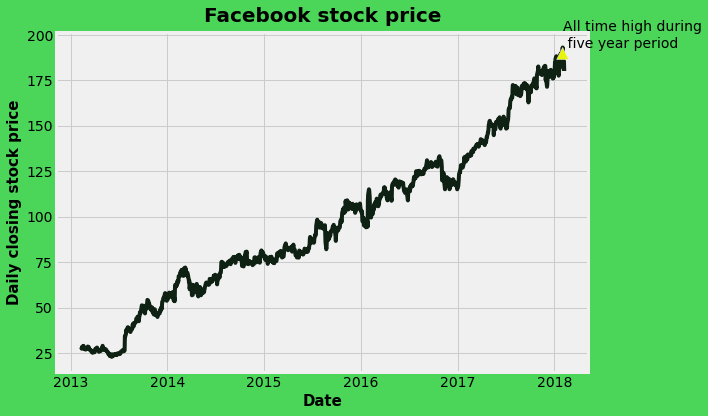

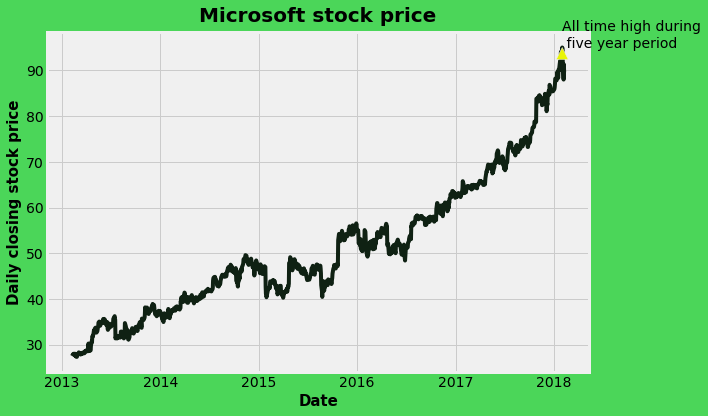

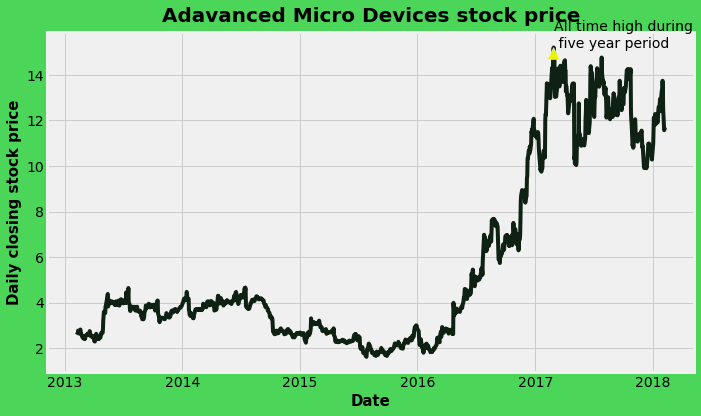

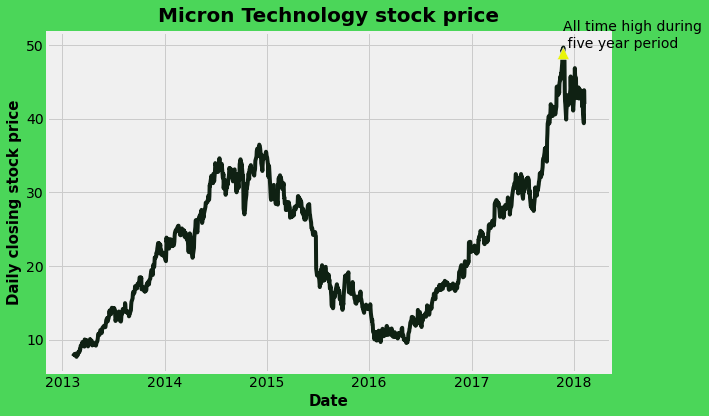

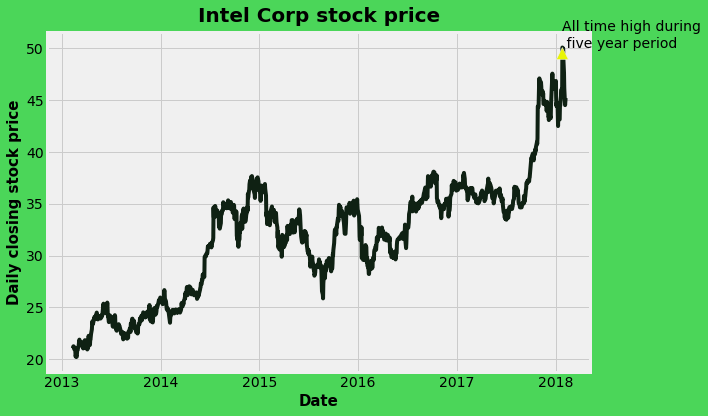

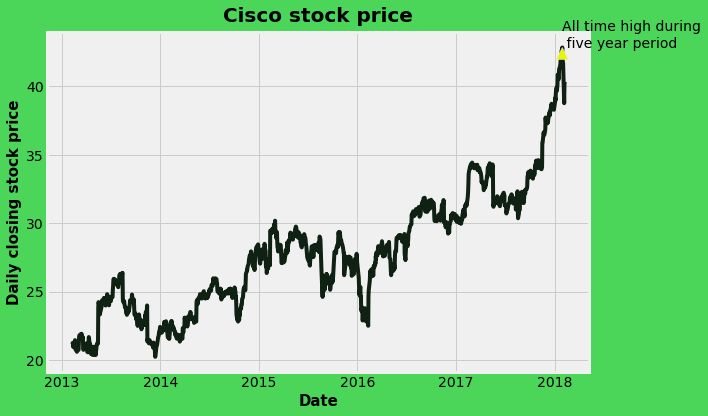

In [9]:
# function return closing stock price over a 5 years of time period
def closing_stock_price(df):
    
    high = df['close'].max()
    datetime = df[df['close'] == df['close'].max()]['date'].values
    
    fig, ax = plt.subplots(figsize=(10,6), facecolor='#4bd659')
    ax.plot(df['date'], df['close'], color='#0f2113')
    ax.set_title(f"{df['co_name'].unique()[0]} stock price", fontsize=20)
    ax.set_xlabel("Date", fontsize=15)
    ax.set_ylabel("Daily closing stock price", fontsize=15)
    ax.annotate("All time high during\n five year period", xy=(datetime, high),
                 arrowprops=dict(facecolor='#e9f507'))
    
    plt.show()
    
# plot of all the closing stocks
closing_stock_price(bac_df)
closing_stock_price(aapl_df)
closing_stock_price(ge_df)
closing_stock_price(f_df)
closing_stock_price(fb_df)
closing_stock_price(msft_df)
closing_stock_price(amd_df)
closing_stock_price(mu_df)
closing_stock_price(intc_df)
closing_stock_price(csco_df)

In [10]:
# question to answer, does daily change in stock price normally distributed and mean of that
# distribution is zero??